Setup

In [1]:
# Use this when restarting session

from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [2]:
# # !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()


In [3]:

from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True

import matplotlib
matplotlib.rc('image', cmap='Greys')

In [4]:

# Setup Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# View GPU details
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!/opt/bin/nvidia-smi
!nvcc --version


Mon Feb  7 05:24:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Initial Settings

In [6]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
CUDA_LAUNCH_BLOCKING=1

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [65]:
path = Path('/content/gdrive/MyDrive/Lonrix_v3/data/')
path.ls()

[PosixPath('/content/gdrive/MyDrive/Lonrix_v3/data/codes.txt'),
 PosixPath('/content/gdrive/MyDrive/Lonrix_v3/data/valid.txt'),
 PosixPath('/content/gdrive/MyDrive/Lonrix_v3/data/images'),
 PosixPath('/content/gdrive/MyDrive/Lonrix_v3/data/colorLabels'),
 PosixPath('/content/gdrive/MyDrive/Lonrix_v3/data/labels'),
 PosixPath('/content/gdrive/MyDrive/Lonrix_v3/data/test_set')]

In [66]:
# Load text from a file. Must specify dtype required, default is float. Each row must be of same length as a pre-requisite.
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Background', 'Potholes'], dtype='<U10')

In [67]:
path_label = path/'labels'
path_img = path/'images'

In [68]:
fnames = get_image_files(path_img)
len(fnames)

35

In [69]:
label_names = get_image_files(path_label)
len(label_names)

35

/content/gdrive/MyDrive/Lonrix_v3/data/images/0200B1L1ROW-276.png


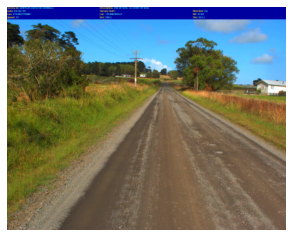

In [70]:
img_f = fnames[30]
print(img_f)
img = open_image(img_f)
img.show(figsize=(5,5))

In [71]:
get_y_fn = lambda x: path_label/f'{x.stem}{x.suffix}'

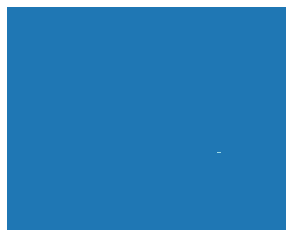

In [72]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [16]:
# # Another way to see the image/mask

# df = pd.DataFrame(array(mask.data)[0])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [73]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([400, 500]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [18]:
# Test on colorLabels data

# color_masks = get_image_files(path/'colorLabels')
# print(color_masks[30])

# get_color = open_mask(color_masks[30])
# get_color.show(figsize=(5,5))
# get_color.data.unique()


In [74]:
size = src_size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs=4

In [75]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [76]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

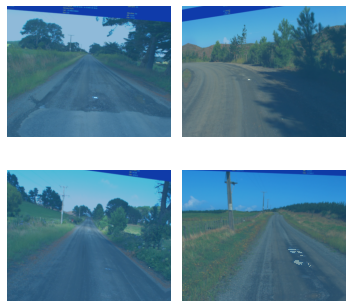

In [77]:
data.show_batch(2, figsize=(5,5))
# ??data.show_batch

In [ ]:
data.show_batch(2, figsize=(5,5), ds_type=DatasetType.Valid)
# data.valid_ds.items
# data.train_ds.items

# data.test_ds.items

# data

In [80]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [81]:
metrics=acc_rtk
wd=1e-2

In [84]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


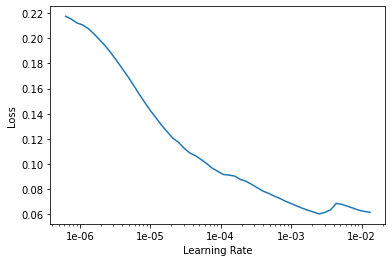

In [86]:
# lr_min,lr_steep = learn.lr_find()
lr_find(learn)
learn.recorder.plot()

In [ ]:
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [87]:
lr = 5e-4

In [88]:
learn.fit_one_cycle(15, slice(lr), pct_start=0.9)

In [ ]:
# learn.recorder.plot_loss()

In [90]:
learn.save('stage-1')

In [91]:
learn.load('stage-1');

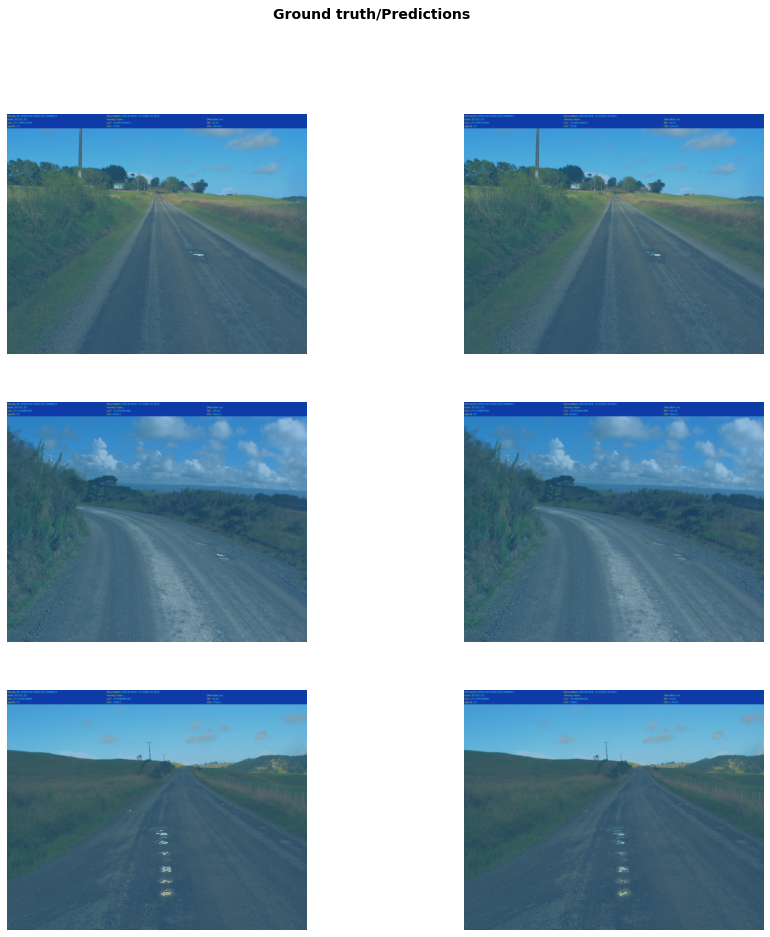

In [92]:
learn.show_results(rows=3, figsize=(15,15))

In [93]:
interp = SegmentationInterpretation.from_learner(learn)

In [94]:
top_losses, top_idxs = interp.top_losses((500,400))

(array([3., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.000181, 0.000289, 0.000397, 0.000506, 0.000614, 0.000723, 0.000831, 0.00094 , 0.001048, 0.001157, 0.001265,
        0.001374, 0.001482, 0.001591, 0.001699, 0.001807, 0.001916, 0.002024, 0.002133, 0.002241, 0.00235 ],
       dtype=float32),
 <a list of 20 Patch objects>)

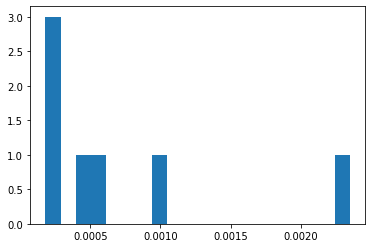

In [95]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [96]:
# top loss idxs of images
top_idxs[:5]

tensor([2, 3, 4, 1, 6])

In [97]:
mean_cm, single_img_cm = interp._generate_confusion()

In [98]:
mean_cm.shape, single_img_cm.shape

((2, 2), (7, 2, 2))

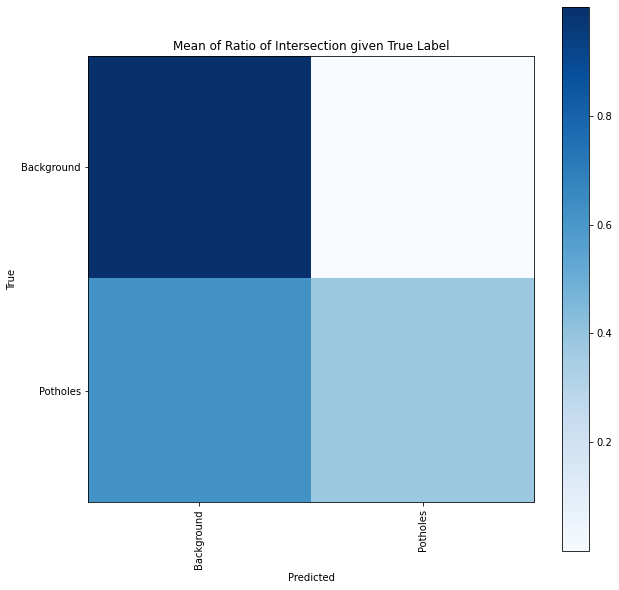

In [99]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

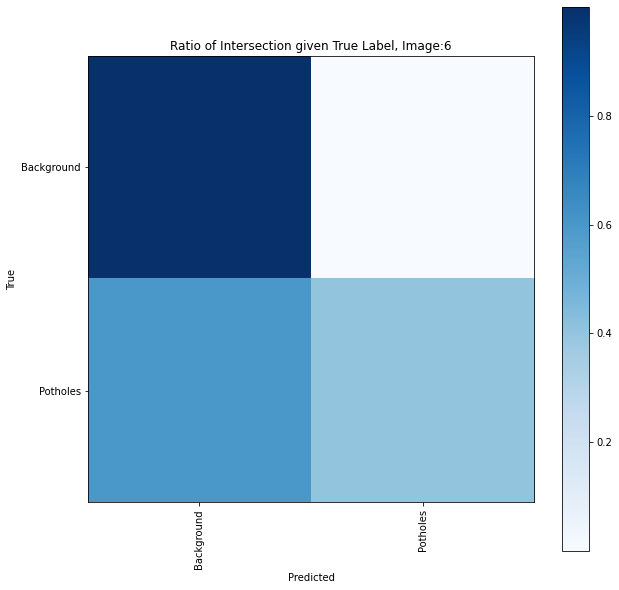

In [100]:
# single image class performance
i = 6
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

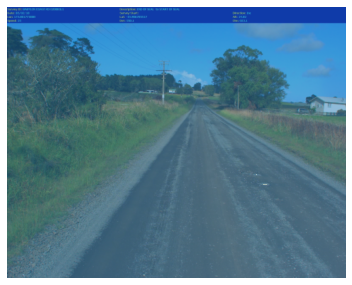

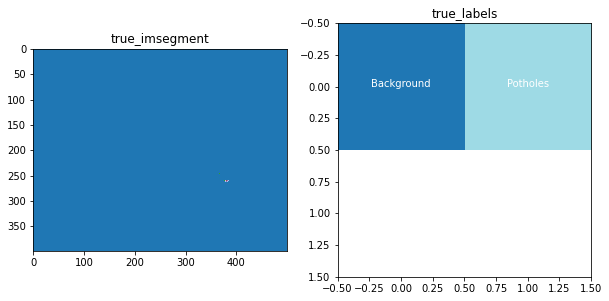

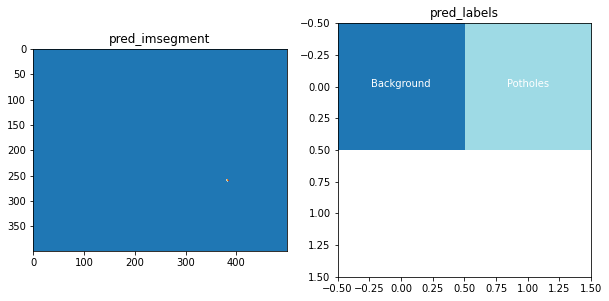

In [101]:
# show xyz
interp.show_xyz(i)

First Model Continuation

In [102]:
learn.unfreeze()

In [103]:
lrs = slice(lr/400,lr/4)

In [104]:
learn.fit_one_cycle(100, lrs, pct_start=0.9)

In [105]:
learn.save('stage-2')

In [106]:
learn.load('stage-2');

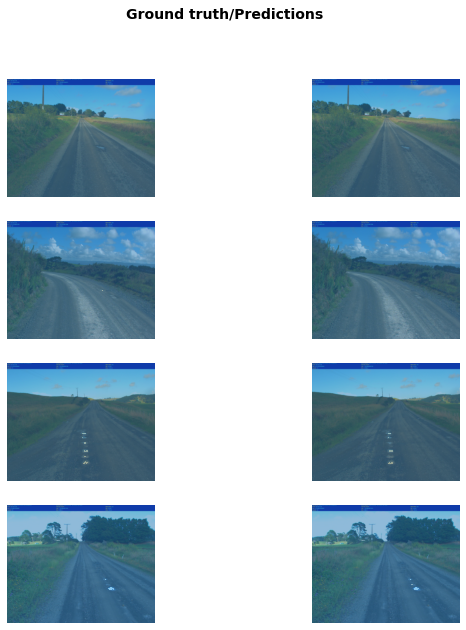

In [107]:
learn.show_results(rows=8, figsize=(10,10))

In [108]:
interp = SegmentationInterpretation.from_learner(learn)

In [109]:
mean_cm, single_img_cm = interp._generate_confusion()

In [110]:
mean_cm.shape, single_img_cm.shape

((2, 2), (7, 2, 2))

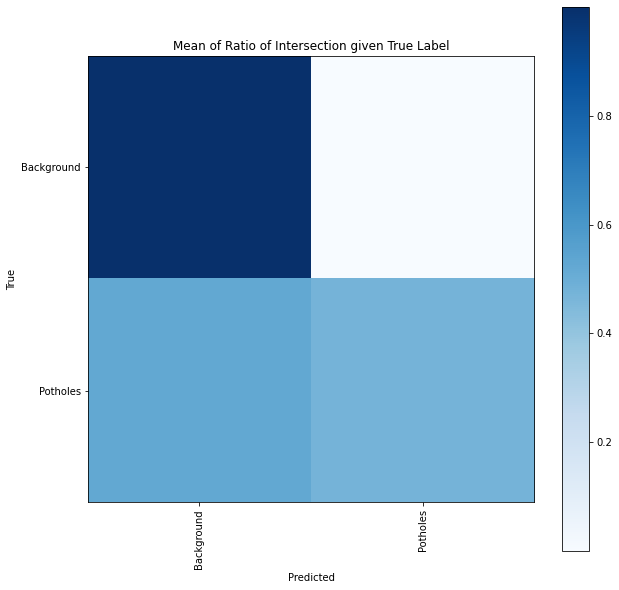

In [111]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

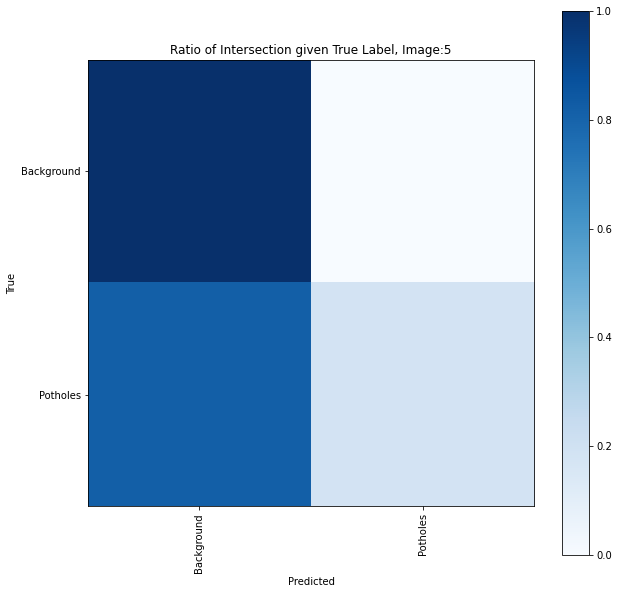

In [112]:
# single image class performance
i = 5
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

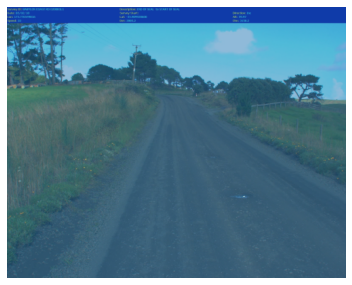

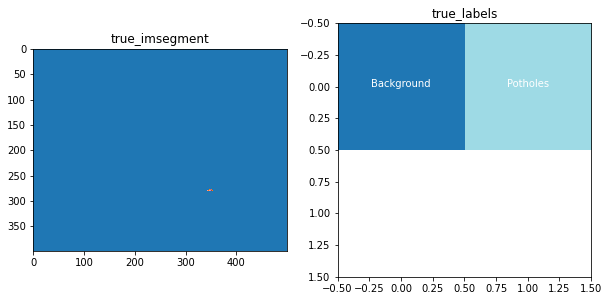

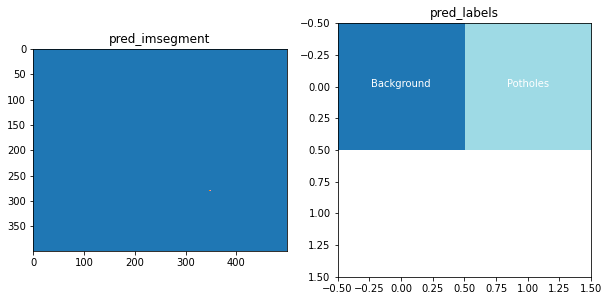

In [113]:
# show xyz
interp.show_xyz(i)

In [114]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (28 items)
x: SegmentationItemList
Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500)
y: SegmentationLabelList
ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500)
Path: /content/gdrive/MyDrive/Lonrix_v3/data/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500)
y: SegmentationLabelList
ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500)
Path: /content/gdrive/MyDrive/Lonrix_v3/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, m

In [116]:
learn.save('stage-2')

In [117]:
data=None
learn=None
gc.collect()

34366

STEP 2: With Weights

In [130]:
size = src_size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs=5

In [131]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [132]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

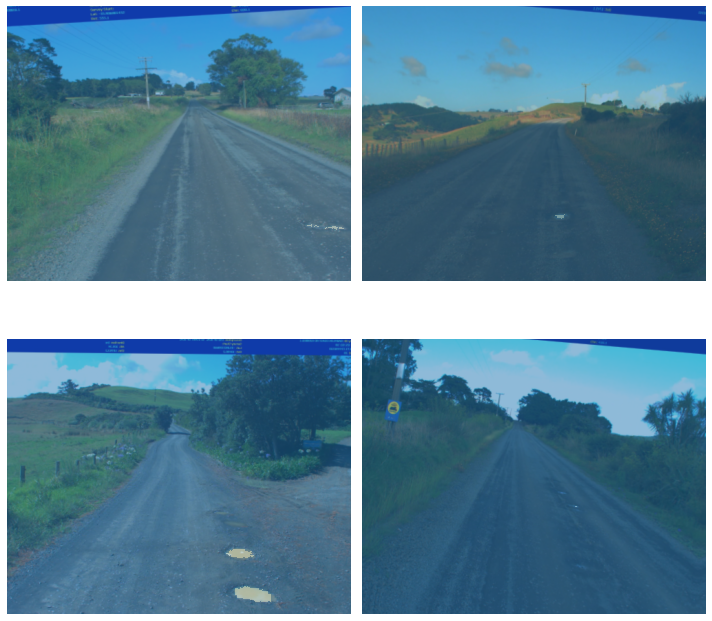

In [133]:
data.show_batch(2, figsize=(10,10))

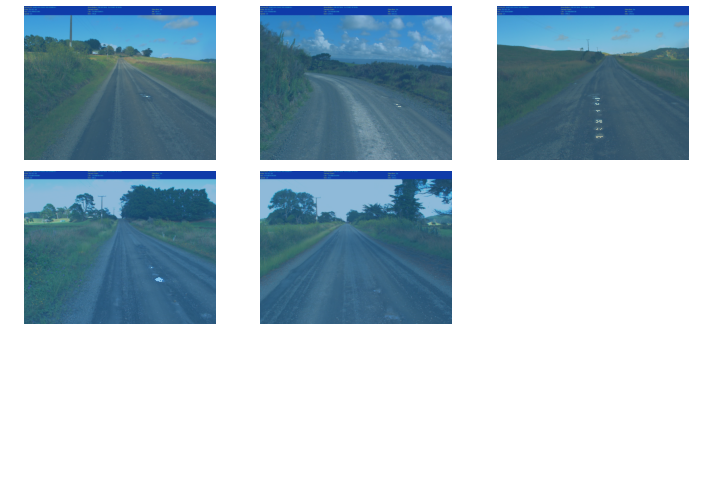

In [134]:
data.show_batch(3, figsize=(10,7), ds_type=DatasetType.Valid)

In [135]:
name2id = {v:k for k,v in enumerate(codes)}
# void_code = name2id['Fourth']
void_code = ""

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [136]:
metrics=acc_rtk
wd=1e-3

In [137]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,20.0]).cuda())

In [138]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)

In [139]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (28 items)
x: SegmentationItemList
Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500)
y: SegmentationLabelList
ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500)
Path: /content/gdrive/MyDrive/Lonrix_v3/data/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500)
y: SegmentationLabelList
ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500)
Path: /content/gdrive/MyDrive/Lonrix_v3/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [140]:
!/opt/bin/nvidia-smi

Mon Feb  7 06:31:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    59W / 149W |   5818MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


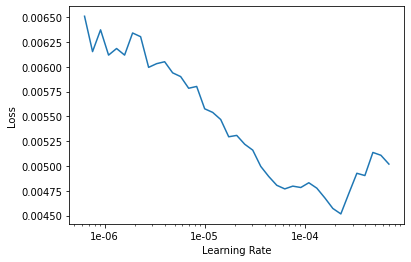

In [141]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [142]:
lr=5e-5

In [143]:
learn.fit_one_cycle(15, slice(lr), pct_start=0.9)

In [144]:
learn.save('stage-1-weights')

In [145]:
learn.load('stage-1-weights');

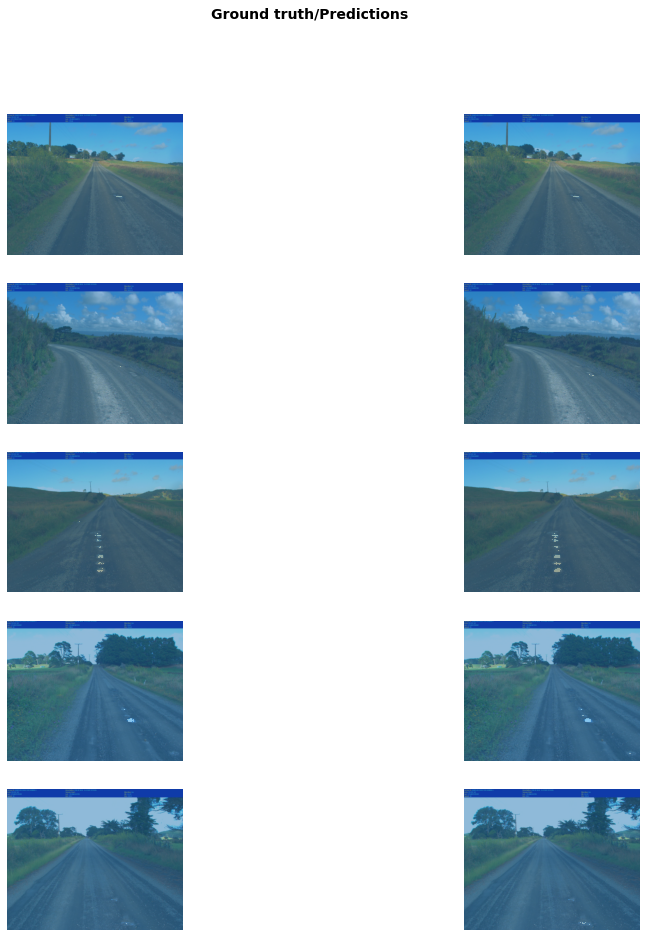

In [150]:
learn.show_results(rows=5, figsize=(15,15))

In [147]:
interp = SegmentationInterpretation.from_learner(learn)

In [148]:
top_losses, top_idxs = interp.top_losses((500,400))

(array([3., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.000277, 0.000563, 0.000849, 0.001135, 0.001421, 0.001707, 0.001993, 0.00228 , 0.002566, 0.002852, 0.003138,
        0.003424, 0.00371 , 0.003996, 0.004282, 0.004569, 0.004855, 0.005141, 0.005427, 0.005713, 0.005999],
       dtype=float32),
 <a list of 20 Patch objects>)

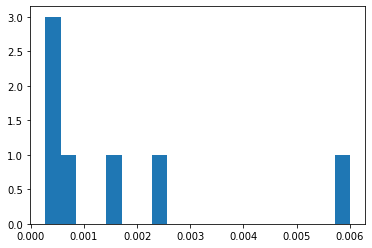

In [151]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [152]:
# top loss idxs of images
top_idxs[:10]

tensor([2, 1, 3, 4, 0, 5, 6])

In [153]:
mean_cm, single_img_cm = interp._generate_confusion()

In [154]:
mean_cm.shape, single_img_cm.shape

((2, 2), (7, 2, 2))

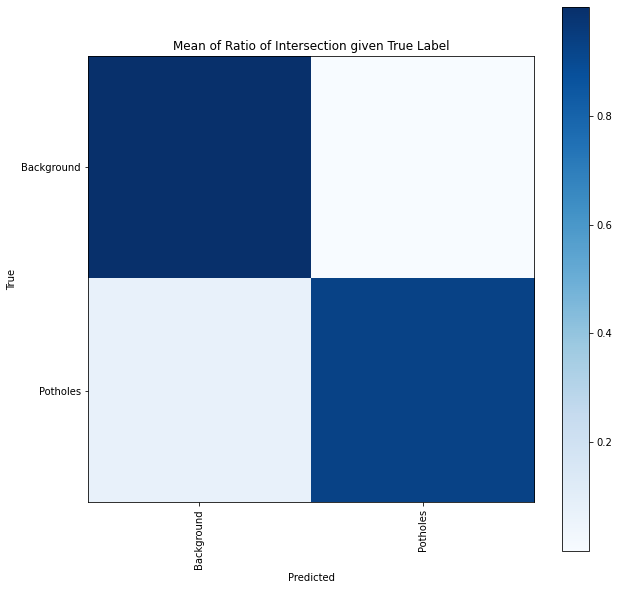

In [155]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

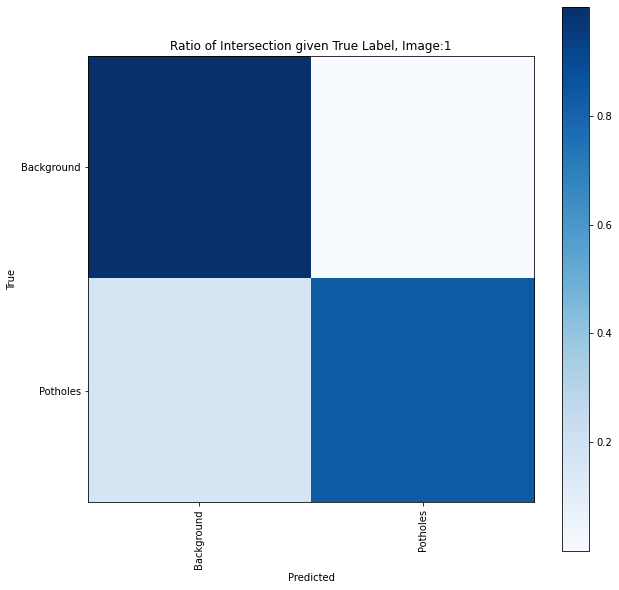

In [156]:
# single image class performance
i = 1
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

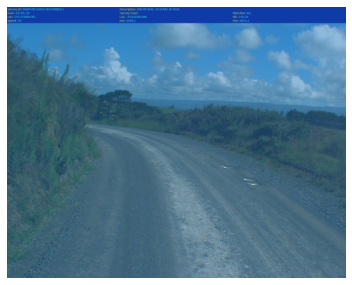

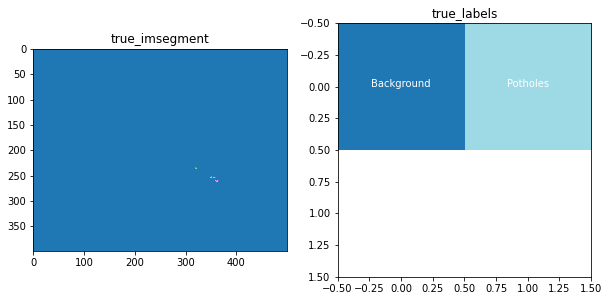

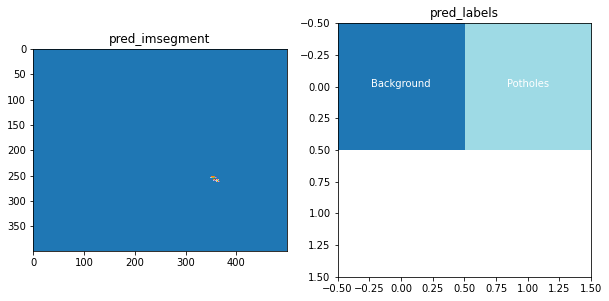

In [157]:
# show xyz
interp.show_xyz(i)

Second Model Continuation

In [158]:
learn.unfreeze()

In [159]:
lrs = slice(lr/400,lr/4)

In [160]:
learn.fit_one_cycle(20, lrs, pct_start=0.8)

In [162]:
learn.save('stage-2-weights')

In [163]:
learn.load('stage-2-weights');

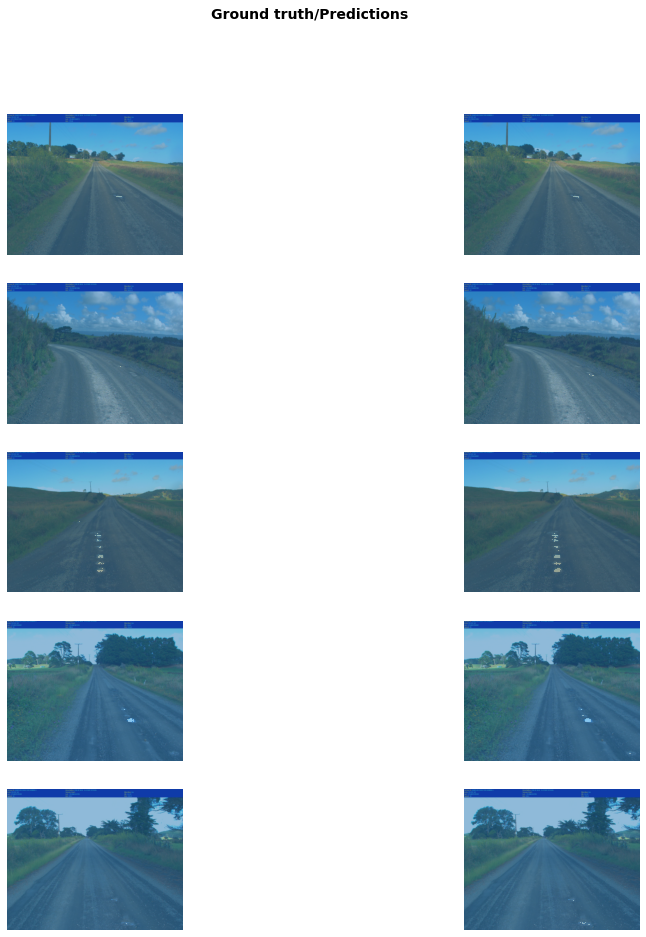

In [167]:
learn.show_results(rows=5, figsize=(15,15))

In [168]:
interp = SegmentationInterpretation.from_learner(learn)

In [169]:
mean_cm, single_img_cm = interp._generate_confusion()

In [170]:
mean_cm.shape, single_img_cm.shape

((2, 2), (7, 2, 2))

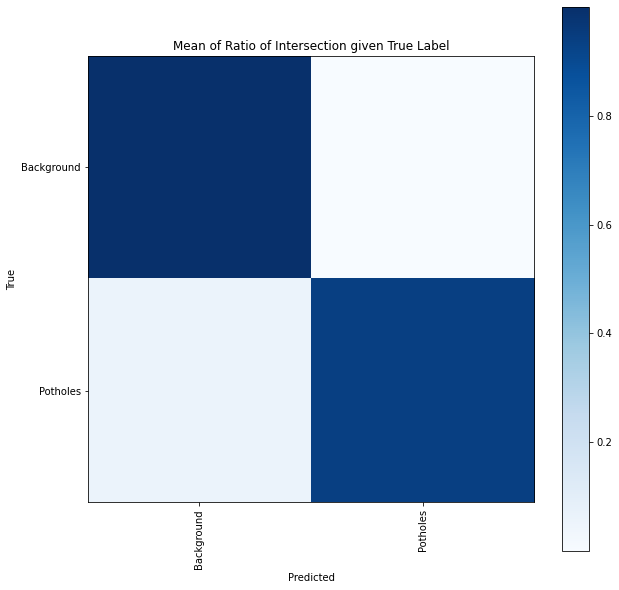

In [171]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

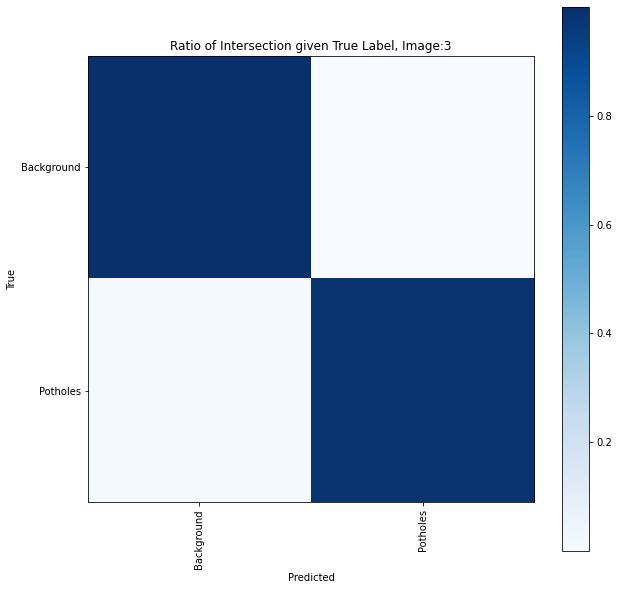

In [177]:
# single image class performance
i = 3
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

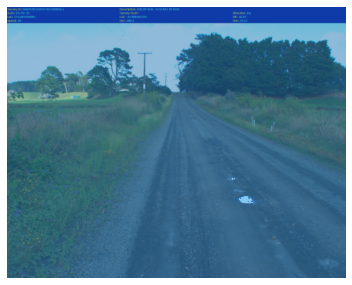

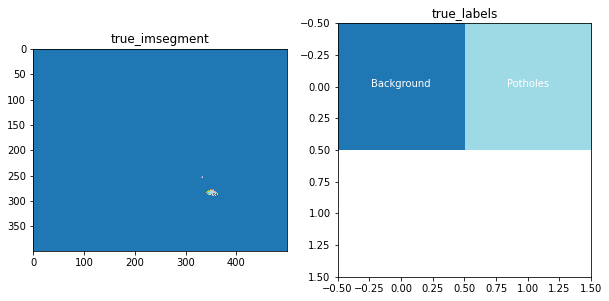

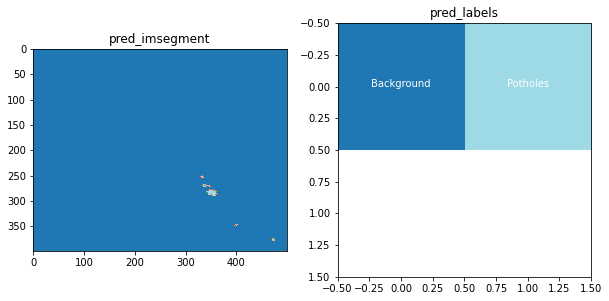

In [178]:
# show xyz
interp.show_xyz(i)

In [179]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (28 items)
x: SegmentationItemList
Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500)
y: SegmentationLabelList
ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500)
Path: /content/gdrive/MyDrive/Lonrix_v3/data/images;

Valid: LabelList (7 items)
x: SegmentationItemList
Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500),Image (3, 400, 500)
y: SegmentationLabelList
ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500),ImageSegment (1, 400, 500)
Path: /content/gdrive/MyDrive/Lonrix_v3/data/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, m

SAVING

In [180]:
learn.save('stage-2-weights')

In [181]:
import os

if 'google.colab' in str(get_ipython()):
  temp_path = Path("/content/gdrive/MyDrive/Lonrix_v3/")

else:
  temp_path = Path(os.getcwd())

learn.path = temp_path

In [182]:
# Save the trained model

learn.export('road_semantic_v3.pkl')

PREDICTIONS FROM FINAL MODEL

In [183]:
size = src_size

# free = gpu_mem_get_free_no_cache()
# # the max size of bs depends on the available GPU RAM
# if free > 8200: bs=8
# else:           bs=4
# print(f"using bs={bs}, have {free}MB of GPU RAM free")

bs=5

In [184]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [185]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [186]:
learn = unet_learner(data, models.resnet34)

In [187]:
learn.load('stage-2-weights');

In [188]:
interp = SegmentationInterpretation.from_learner(learn)

In [189]:
mean_cm, single_img_cm = interp._generate_confusion()

In [190]:
mean_cm.shape, single_img_cm.shape

((2, 2), (7, 2, 2))

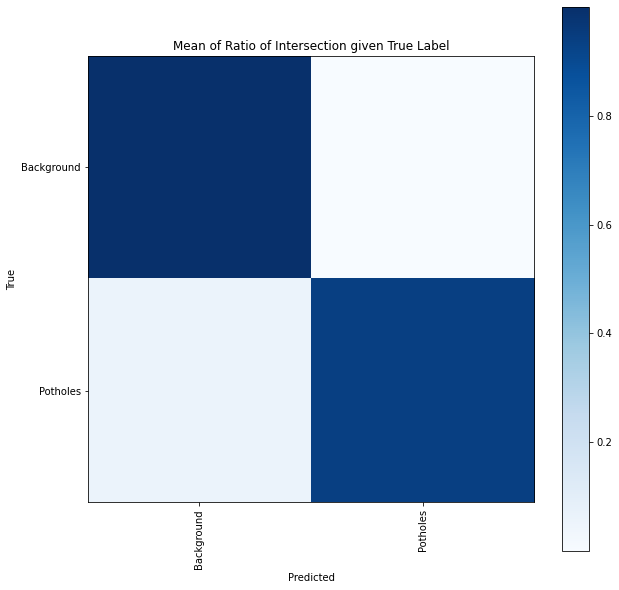

In [191]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

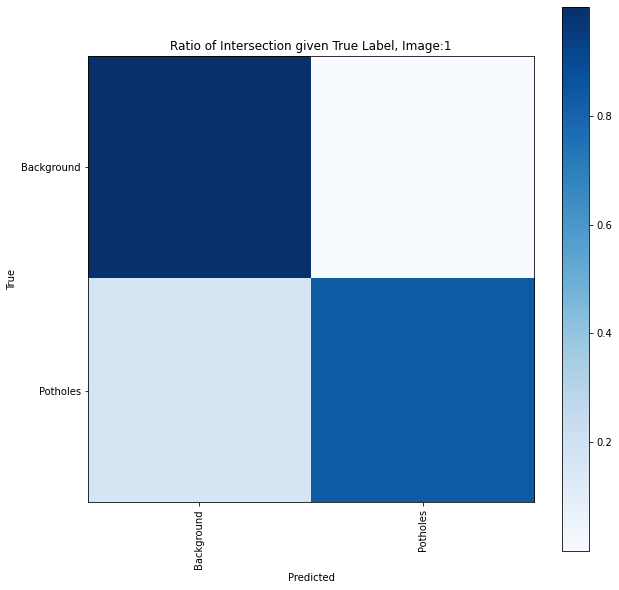

In [192]:
# single image class performance
i = 1
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

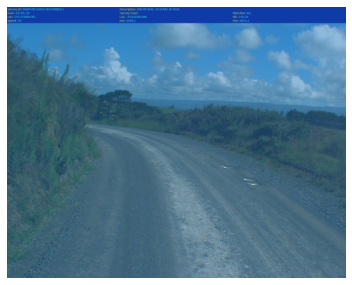

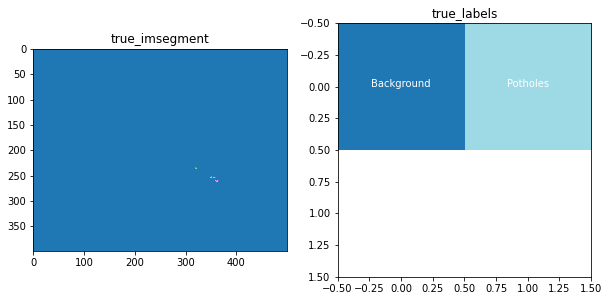

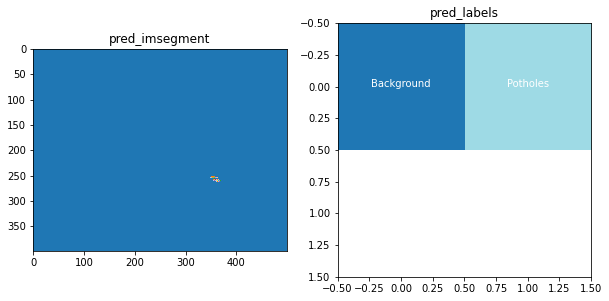

In [193]:
# show xyz
interp.show_xyz(i)

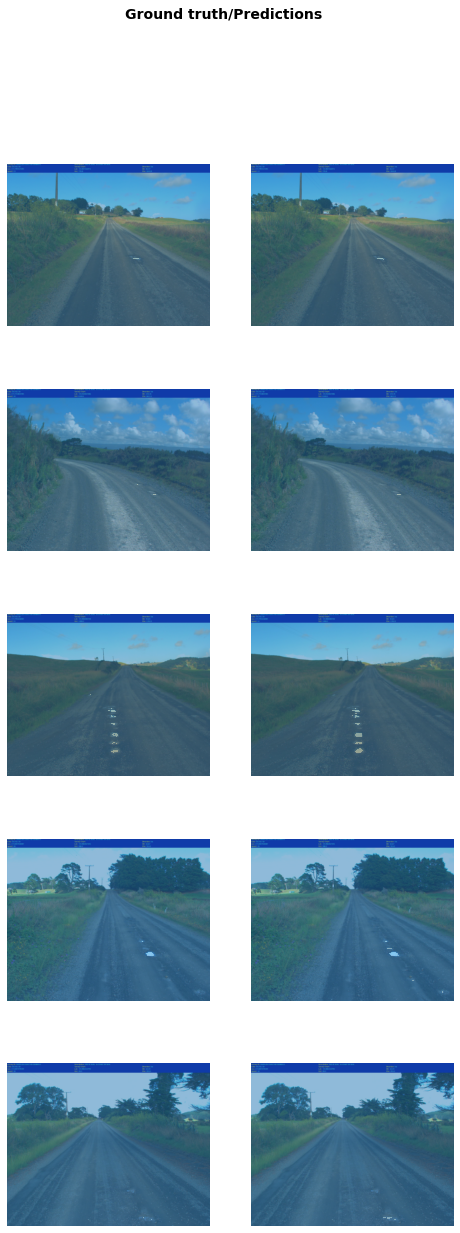

In [194]:
learn.show_results()

In [ ]:
# interp.plot_top_losses(5, nrows=1)

In [ ]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner

SAVING RESULTS

In [225]:
files = get_image_files(Path("/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images"))
# files = get_image_files(Path("/content/gdrive/MyDrive/Lonrix_v3/data/test_set/POTHOLES"))
len(files)

22

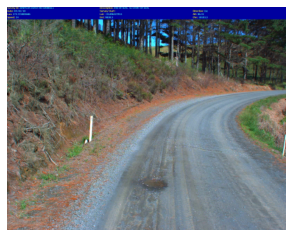

In [226]:
img_f = files[5]
img = open_image(img_f)
img.show(figsize=(5,5))

In [227]:
prediction = learn.predict(img)

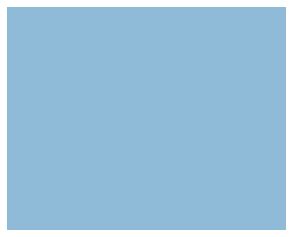

In [228]:
prediction[0].show(figsize=(5,5))

In [229]:
test_set = Path("/content/gdrive/MyDrive/Lonrix_v3/data/test_set")

results_save = 'results'
new_rst = test_set/results_save
print(new_rst)

new_rst.mkdir(exist_ok=True)

/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results


In [230]:
import os 

def save_preds(names):
    i=0
    # names = dl.dataset.items
    
    for b in names:
        img_s = files[i]
        print(img_s)

        img_toSave = open_image(img_s)

        img_s = f'{img_s}'

        filename = img_s.strip().split('/')[-1]
        print(filename)

        predictionSave = learn.predict(img_toSave)
        
        predictionSave[0].save(new_rst/filename) #Save Image
        print(new_rst/filename)

        i += 1
        print(i)
    
    
    print("Done")

Done


In [231]:
save_preds(files)

/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images/0200B1L1ROW-1372.png
0200B1L1ROW-1372.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results/0200B1L1ROW-1372.png
1
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images/0200B1L1ROW-250.png
0200B1L1ROW-250.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results/0200B1L1ROW-250.png
2
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images/0200B1L1ROW-320.png
0200B1L1ROW-320.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results/0200B1L1ROW-320.png
3
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images/0200B1L1ROW-158.png
0200B1L1ROW-158.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results/0200B1L1ROW-158.png
4
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images/0200B1L1ROW-266.png
0200B1L1ROW-266.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results/0200B1L1ROW-266.png
5
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/images/0200B1L1ROW-4916.png
0200B1L1ROW-4916.png
/content/gdrive/MyDrive/Lonrix_v3/d

COLOURING RESULTS

In [215]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.1.2'

In [216]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [217]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 400
  height = 500
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #Pothole
        frame[x, y] = (100,255,100)
      # elif (b, g, r) == (2,2,2): #roadPaved
      #   frame[x, y] = (85,170,127)
      # elif (b, g, r) == (3,3,3): #roadUnpaved
      #   frame[x, y] = (255,170,127) 
      # elif (b, g, r) == (4,4,4): #roadMarking
      #   frame[x, y] = (255,255,255) 
      # elif (b, g, r) == (5,5,5): #speedBump
      #   frame[x, y] = (255,85,255)
      # elif (b, g, r) == (6,6,6): #catsEye
      #   frame[x, y] = (255,255,127)          
      # elif (b, g, r) == (7,7,7): #stormDrain
      #   frame[x, y] = (170,0,127) 
      # elif (b, g, r) == (8,8,8): #manholeCover
      #   frame[x, y] = (0,255,255) 
      # elif (b, g, r) == (9,9,9): #patchs
      #   frame[x, y] = (0,0,127) 
      # elif (b, g, r) == (10,10,10): #waterPuddle
      #   frame[x, y] = (170,0,0)
      # elif (b, g, r) == (11,11,11): #pothole
      #   frame[x, y] = (255,0,0)
      # elif (b, g, r) == (12,12,12): #cracks
      #   frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [232]:
colored_results = 'results_color'
path_crst = test_set/colored_results
print(path_crst)
path_crst.mkdir(exist_ok=True)


import timeit
# Count variables
fqtd = 0

# print(new_rst)
filenames = [img for img in glob.glob(str(new_rst/"*"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  
  img_split = f'{img}'
  # print(img_split)

  filename = img_split.strip().split('/')[-1]
  print(filename)

  destination = os.path.join(path_crst, filename)
  print(destination)
  cv.imwrite(destination, frame)

  fqtd += 1
  print(fqtd)

print("Done!")

/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color
0200B1L1ROW-1317.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-1317.png
1
0200B1L1ROW-1372.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-1372.png
2
0200B1L1ROW-1514.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-1514.png
3
0200B1L1ROW-158.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-158.png
4
0200B1L1ROW-1641.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-1641.png
5
0200B1L1ROW-1646.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-1646.png
6
0200B1L1ROW-1829.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-1829.png
7
0200B1L1ROW-246.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-246.png
8
0200B1L1ROW-250.png
/content/gdrive/MyDrive/Lonrix_v3/data/test_set/results_color/0200B1L1ROW-